# set path

In [51]:
import os
try:
    from google.colab import drive
    drive.mount('/content/drive/', force_remount=False)
    rootpath = '/content/drive/My Drive/ai-side-projects/self-supervised-halos/data/freya_postprocess/'
except:
    %matplotlib inline
    rootpath = '/Users/sdbykov/work/self-supervised-halos/data/freya_postprocess/'
os.chdir(rootpath)

# Imports

In [52]:
import torch
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from glob import glob
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

from torch.utils.data import TensorDataset, DataLoader



try:
    subhalos_df = pd.read_pickle(rootpath+'/subhalos_df.pkl')
except:
    subhalos_df = pd.read_pickle('/Users/sdbykov/work/self-supervised-halos/data/subhalos_df.pkl')
subhalos_df['logSubhaloMass'] = np.log10(subhalos_df['SubhaloMass']*1e10/0.6774)



# Data loaders and transformers

In [ ]:

class HaloDataset(torch.utils.data.Dataset):
    mass_bins = np.linspace(11, 14.7, 11)

    def __init__(self, root_dir, load_3d = False):
        self.root_dir = root_dir
        
        self.files = glob(root_dir+'*.npz')
        self.halos_ids = [int(x.split('_')[-1].split('.')[0]) for x in self.files]

        self.load_3d = load_3d

    def __len__(self):
        return len(self.halos_ids)
    
    def __getitem__(self, idx):
        halo_id = self.halos_ids[idx]
        fname_root = f'{self.root_dir}halo_{halo_id}'

        data = np.load(fname_root+'.npz')
        data_xy = data['map_2d_xy']
    
        data_xz = data['map_2d_xz']
        data_yz = data['map_2d_yz']
        snap = data['snap']
        snap_mass = data['mass']
        data_3d = data['map_3d'] 

        label_mass = subhalos_df.loc[halo_id]['logSubhaloMass']
        label_class = np.digitize(label_mass, self.mass_bins)
        label = (label_mass, label_class)

        del data
        
        #make 2d data as 1 channel images
        data_xy = np.expand_dims(data_xy, axis=0)
        data_xz = np.expand_dims(data_xz, axis=0)
        data_yz = np.expand_dims(data_yz, axis=0)
        
        tuple_to_resuts = data_3d,(data_xy, data_xz, data_yz), (snap, snap_mass)

        return tuple_to_resuts, label
    

In [53]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
if device=='cuda':
    print(torch.cuda.get_device_properties(0).name)


cpu


In [54]:
dataset = HaloDataset(rootpath, load_3d = False)
dataloader = DataLoader(dataset, batch_size=10, shuffle=True) 

batch_data, batch_label = next(iter(dataloader))

batch_data = batch_data[1]

In [55]:
class RandomRotationWithMinFill:
    def __init__(self, degrees):
        self.degrees = degrees

    def __call__(self, img):
        # Ensure the input is a tensor
        if not isinstance(img, torch.Tensor):
            raise TypeError("Input should be a tensor")

        # Get the minimum value of the original image
        min_val = img.min()
        #min_val = 0

        # Rotate the image
        angle = torch.empty(1).uniform_(-self.degrees, self.degrees).item()
        rotated_img = torchvision.transforms.functional.rotate(img, angle=angle)

        # Create a mask where the rotated image is zero
        mask = rotated_img == 0

        # Fill the masked area with the minimum value of the original image
        rotated_img[mask] = min_val

        return rotated_img


contrast_transforms = transforms.Compose([
    transforms.RandomResizedCrop(size=(64, 64), scale=(0.5, 0.95)),
    RandomRotationWithMinFill(degrees=180),
])


def select_views_and_transform(projections, transform = contrast_transforms):
    i1, i2 = np.random.choice(3, 2, replace=False) #TODO replace False or True? If True, then the same view can be selected twice
    view1 = projections[i1]
    view2 = projections[i2]

    view1 = transform(view1)
    view2 = transform(view2)

    return view1, view2

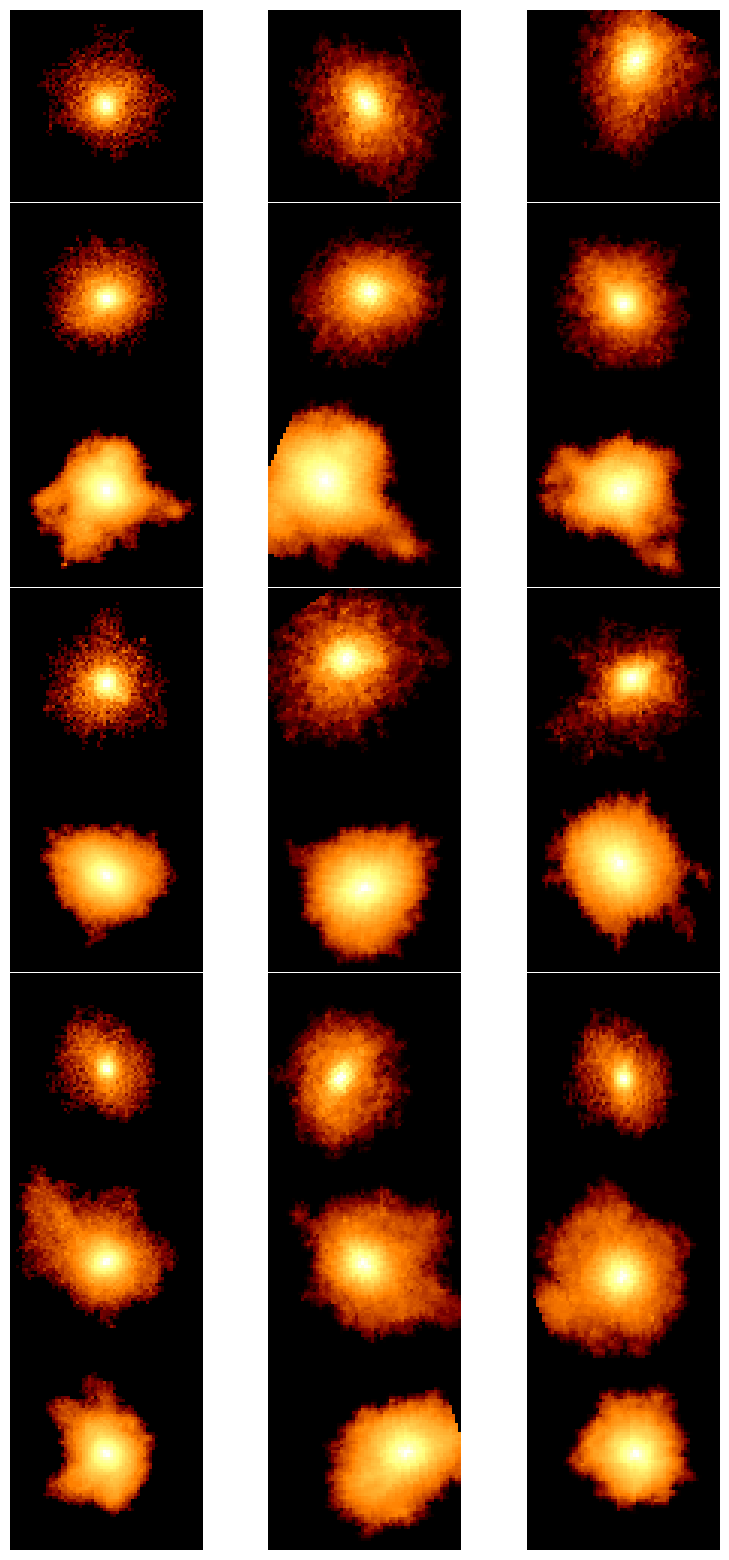

In [56]:
fig, axs = plt.subplots(8, 3, figsize=(10, 20))

for i in range(8):
    orig_xy = batch_data[0][i]
    orig_xz = batch_data[1][i]
    orig_yz = batch_data[2][i]
    origs = [orig_xy, orig_xz, orig_yz]

    view_1, view_2 = select_views_and_transform(origs)


    orig_xy = orig_xy.squeeze()
    view_1 = view_1.squeeze()
    view_2 = view_2.squeeze()

    axs[i, 0].imshow(orig_xy, cmap='afmhot')
    axs[i, 1].imshow(view_1, cmap='afmhot')
    axs[i, 2].imshow(view_2, cmap='afmhot')

    axs[i, 0].axis('off')
    axs[i, 1].axis('off')
    axs[i, 2].axis('off')

#remove space between subplots
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()


# Contrastive loss

---